## HW 2 ##

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
env_slippery = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"], map_name="4x4", is_slippery=True)
env_non_slippery = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"], map_name="4x4", is_slippery=False)

In [8]:
# Reward function
# 0 for each step until you reach the goal
# 1 if you reach the goal
# 0 if you fall in a hole

# discount factor (gamma)
gamma = 0.95

# State Space
# 0 to 15 (16 states in total, 1 for each cell in the 4x4 grid)

# Action Space
# 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP

# Transition Probabilities
# 1/3 chance of moving in the intended direction
# 1/3 chance of moving in either perpendicular direction


In [9]:
def evaluate_policy_from_initial_state(env, Q, num_eval_episodes, gamma, max_steps=1000):
    """Evaluate greedy policy from initial state"""
    returns = []
    for _ in range(num_eval_episodes):
        state, _ = env.reset()
        episode_return = 0
        done = False
        discount = 1.0
        steps = 0
        
        while not done and steps < max_steps:
            action = np.argmax(Q[state])  # Greedy policy
            next_state, reward, done, _, _ = env.step(action)
            episode_return += discount * reward
            discount *= gamma
            state = next_state
            steps += 1
        
        returns.append(episode_return)
    return np.mean(returns)

In [10]:
def sarsa_on_policy(env, num_episodes, alpha=0.1, epsilon_start=1.0, epsilon_end=0.0,
                    epsilon_decay_ratio=0.8, gamma=0.95,
                    eval_interval=50, eval_episodes=100, num_runs=30, max_steps=1000):
    all_timesteps = []
    all_returns = []
    all_Q = []
   
    for run in range(num_runs):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
       
        run_timesteps = []
        run_returns = []
        total_timesteps = 0
       
        for episode in range(num_episodes):
            # Episode-based linear decay
            # Decays over first epsilon_decay_ratio fraction of episodes
            decay_episodes = int(num_episodes * epsilon_decay_ratio)
            epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (episode / decay_episodes))
           
            state, _ = env.reset()
           
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(Q[state])
           
            done = False
            steps = 0
            while not done and steps < max_steps:
                next_state, reward, done, _, _ = env.step(action)
               
                if not done:
                    # Use SAME epsilon throughout episode
                    if np.random.rand() < epsilon:
                        next_action = np.random.choice(env.action_space.n)
                    else:
                        next_action = np.argmax(Q[next_state])
                   
                    Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
                    action = next_action
                else:
                    Q[state, action] += alpha * (reward - Q[state, action])
               
                state = next_state
                total_timesteps += 1
                steps += 1
           
            if (episode + 1) % eval_interval == 0:
                eval_return = evaluate_policy_from_initial_state(env, Q, eval_episodes, gamma, max_steps=max_steps)
                run_timesteps.append(total_timesteps)
                run_returns.append(eval_return)
       
        all_timesteps.append(run_timesteps)
        all_returns.append(run_returns)
        all_Q.append(Q.copy())
        print(f"SARSA Run {run+1}/{num_runs} complete")
    return all_timesteps, all_returns, all_Q


def q_learning(env, num_episodes, alpha=0.1, epsilon_start=1.0, epsilon_end=0.0,
               epsilon_decay_ratio=0.8, gamma=0.95,
               eval_interval=50, eval_episodes=100, num_runs=30, max_steps=1000):
    all_timesteps = []
    all_returns = []
    all_Q = []
   
    for run in range(num_runs):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
       
        run_timesteps = []
        run_returns = []
        total_timesteps = 0
       
        for episode in range(num_episodes):
            # Episode-based linear decay
            decay_episodes = int(num_episodes * epsilon_decay_ratio)
            epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (episode / decay_episodes))
           
            state, _ = env.reset()
            done = False
            steps = 0
           
            while not done and steps < max_steps:
                if np.random.rand() < epsilon:
                    action = np.random.choice(env.action_space.n)
                else:
                    action = np.argmax(Q[state])
               
                next_state, reward, done, _, _ = env.step(action)
               
                if not done:
                    Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
                else:
                    Q[state, action] += alpha * (reward - Q[state, action])
               
                state = next_state
                total_timesteps += 1
                steps += 1
           
            if (episode + 1) % eval_interval == 0:
                eval_return = evaluate_policy_from_initial_state(env, Q, eval_episodes, gamma, max_steps=max_steps)
                run_timesteps.append(total_timesteps)
                run_returns.append(eval_return)
       
        all_timesteps.append(run_timesteps)
        all_returns.append(run_returns)
        all_Q.append(Q.copy())
        print(f"Q-Learning Run {run+1}/{num_runs} complete")
   
    return all_timesteps, all_returns, all_Q


def first_visit_mc_control(env, num_episodes, epsilon_start=0.3, epsilon_end=0.0,
                           epsilon_decay_ratio=0.8, gamma=0.95,
                           eval_interval=50, eval_episodes=100, num_runs=30, max_steps=1000):
    all_timesteps = []
    all_returns = []
    all_Q = []
   
    for run in range(num_runs):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        returns_dict = {}
       
        run_timesteps = []
        run_returns = []
        total_timesteps = 0
       
        for episode in range(num_episodes):
            # Episode-based linear decay
            decay_episodes = int(num_episodes * epsilon_decay_ratio)
            epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (episode / decay_episodes))
            
            # Update policy to be epsilon-soft
            policy = np.ones((env.observation_space.n, env.action_space.n)) * (epsilon / env.action_space.n)
            for s in range(env.observation_space.n):
                best_action = np.argmax(Q[s])
                policy[s, best_action] += (1 - epsilon)
            
            state, _ = env.reset()
            episode_data = []
            done = False
            steps = 0
           
            while not done and steps < max_steps:
                action = np.random.choice(np.arange(env.action_space.n), p=policy[state])
                next_state, reward, done, _, _ = env.step(action)
                episode_data.append((state, action, reward))
                state = next_state
                total_timesteps += 1
                steps += 1
           
            # Update Q values
            G = 0
            visited = set()
            for t in reversed(range(len(episode_data))):
                state, action, reward = episode_data[t]
                G = gamma * G + reward
               
                if (state, action) not in visited:
                    visited.add((state, action))
                    if (state, action) not in returns_dict:
                        returns_dict[(state, action)] = []
                    returns_dict[(state, action)].append(G)
                    Q[state, action] = np.mean(returns_dict[(state, action)])
           
            if (episode + 1) % eval_interval == 0:
                eval_return = evaluate_policy_from_initial_state(env, Q, eval_episodes, gamma, max_steps=max_steps)
                run_timesteps.append(total_timesteps)
                run_returns.append(eval_return)
       
        all_timesteps.append(run_timesteps)
        all_returns.append(run_returns)
        all_Q.append(Q.copy())
        print(f"MC Control Run {run+1}/{num_runs} complete")
   
    return all_timesteps, all_returns, all_Q

In [11]:
gamma = 0.95

ql_timesteps, ql_returns, ql_Q = q_learning(
    env_slippery, num_episodes=1000
)

sarsa_timesteps, sarsa_returns, sarsa_Q = sarsa_on_policy(
    env_slippery, num_episodes=1000
)

mc_timesteps, mc_returns, mc_Q = first_visit_mc_control(
    env_slippery, num_episodes=1000
)


Q-Learning Run 1/30 complete
Q-Learning Run 2/30 complete
Q-Learning Run 3/30 complete
Q-Learning Run 4/30 complete
Q-Learning Run 5/30 complete
Q-Learning Run 6/30 complete
Q-Learning Run 7/30 complete
Q-Learning Run 8/30 complete
Q-Learning Run 9/30 complete
Q-Learning Run 10/30 complete
Q-Learning Run 11/30 complete
Q-Learning Run 12/30 complete
Q-Learning Run 13/30 complete
Q-Learning Run 14/30 complete
Q-Learning Run 15/30 complete
Q-Learning Run 16/30 complete
Q-Learning Run 17/30 complete
Q-Learning Run 18/30 complete
Q-Learning Run 19/30 complete
Q-Learning Run 20/30 complete
Q-Learning Run 21/30 complete
Q-Learning Run 22/30 complete
Q-Learning Run 23/30 complete
Q-Learning Run 24/30 complete
Q-Learning Run 25/30 complete
Q-Learning Run 26/30 complete
Q-Learning Run 27/30 complete
Q-Learning Run 28/30 complete
Q-Learning Run 29/30 complete
Q-Learning Run 30/30 complete
SARSA Run 1/30 complete
SARSA Run 2/30 complete
SARSA Run 3/30 complete
SARSA Run 4/30 complete
SARSA Run 5/3

In [12]:
# non-slippery environment runs
ql_timesteps_ns, ql_returns_ns, ql_Q_ns = q_learning(
    env_non_slippery, num_episodes=1000
)

sarsa_timesteps_ns, sarsa_returns_ns, sarsa_Q_ns = sarsa_on_policy(
    env_non_slippery, num_episodes=1000
)

mc_timesteps_ns, mc_returns_ns, mc_Q_ns = first_visit_mc_control(
    env_non_slippery, num_episodes=1000
)

Q-Learning Run 1/30 complete
Q-Learning Run 2/30 complete
Q-Learning Run 3/30 complete
Q-Learning Run 4/30 complete
Q-Learning Run 5/30 complete
Q-Learning Run 6/30 complete
Q-Learning Run 7/30 complete
Q-Learning Run 8/30 complete
Q-Learning Run 9/30 complete
Q-Learning Run 10/30 complete
Q-Learning Run 11/30 complete
Q-Learning Run 12/30 complete
Q-Learning Run 13/30 complete
Q-Learning Run 14/30 complete
Q-Learning Run 15/30 complete
Q-Learning Run 16/30 complete
Q-Learning Run 17/30 complete
Q-Learning Run 18/30 complete
Q-Learning Run 19/30 complete
Q-Learning Run 20/30 complete
Q-Learning Run 21/30 complete
Q-Learning Run 22/30 complete
Q-Learning Run 23/30 complete
Q-Learning Run 24/30 complete
Q-Learning Run 25/30 complete
Q-Learning Run 26/30 complete
Q-Learning Run 27/30 complete
Q-Learning Run 28/30 complete
Q-Learning Run 29/30 complete
Q-Learning Run 30/30 complete
SARSA Run 1/30 complete
SARSA Run 2/30 complete
SARSA Run 3/30 complete
SARSA Run 4/30 complete
SARSA Run 5/3

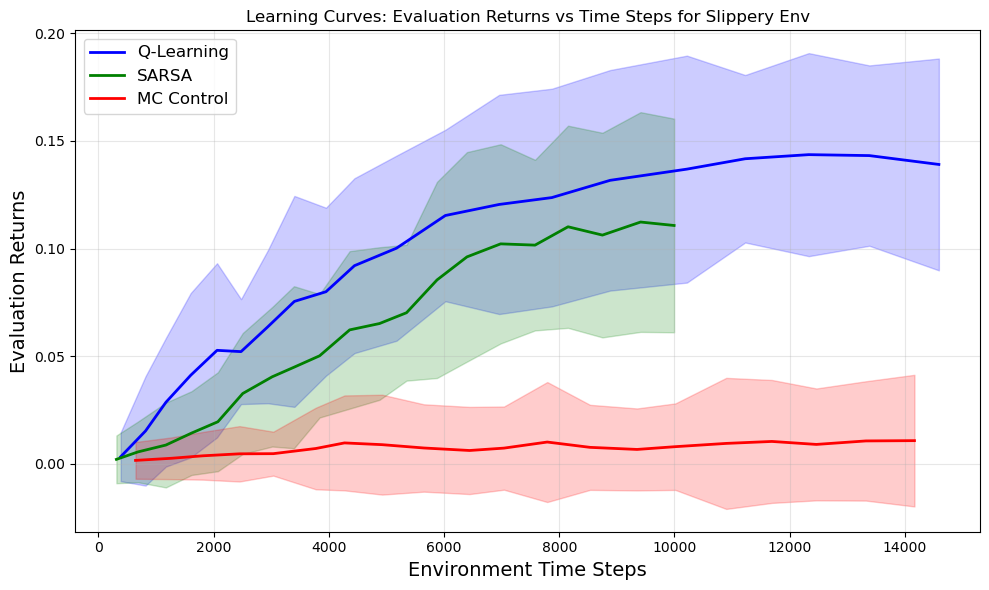

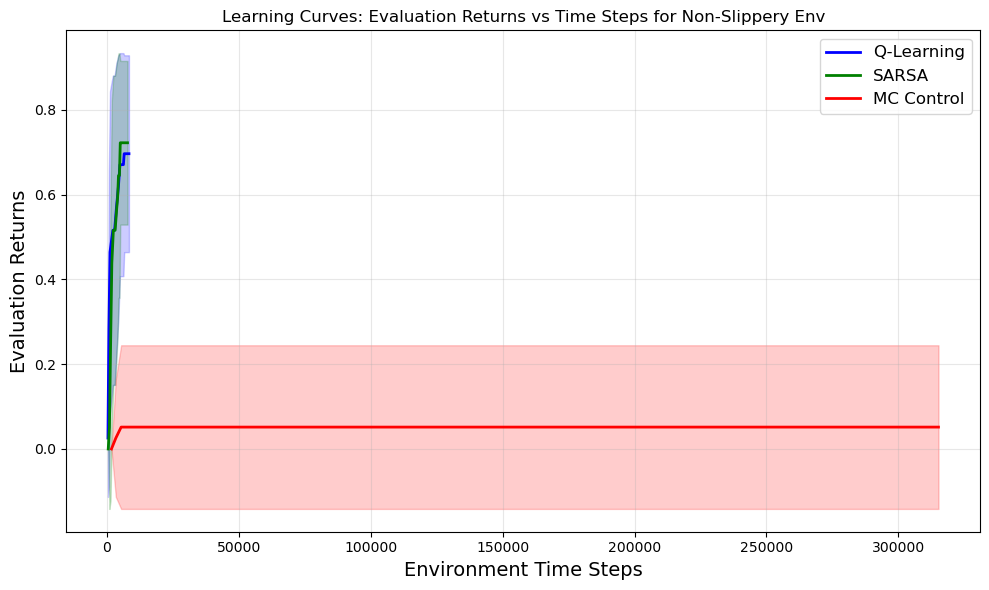

In [13]:
def plot_learning_curves_s(ql_data, sarsa_data, mc_data):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Process Q-Learning
    ql_timesteps_array = np.array(ql_data[0])
    ql_returns_array = np.array(ql_data[1])
    ql_mean = np.mean(ql_returns_array, axis=0)
    ql_std = np.std(ql_returns_array, axis=0)
    ql_timesteps = ql_timesteps_array[0] 
    
    # Process SARSA
    sarsa_timesteps_array = np.array(sarsa_data[0])
    sarsa_returns_array = np.array(sarsa_data[1])
    sarsa_mean = np.mean(sarsa_returns_array, axis=0)
    sarsa_std = np.std(sarsa_returns_array, axis=0)
    sarsa_timesteps = sarsa_timesteps_array[0]
    
    # Process MC Control
    mc_timesteps_array = np.array(mc_data[0])
    mc_returns_array = np.array(mc_data[1])
    mc_mean = np.mean(mc_returns_array, axis=0)
    mc_std = np.std(mc_returns_array, axis=0)
    mc_timesteps = mc_timesteps_array[0]
    
    # Plot
    ax.plot(ql_timesteps, ql_mean, linewidth=2, label='Q-Learning', color='blue')
    ax.fill_between(ql_timesteps, ql_mean - ql_std, ql_mean + ql_std, alpha=0.2, color='blue')
    
    ax.plot(sarsa_timesteps, sarsa_mean, linewidth=2, label='SARSA', color='green')
    ax.fill_between(sarsa_timesteps, sarsa_mean - sarsa_std, sarsa_mean + sarsa_std, alpha=0.2, color='green')
    
    ax.plot(mc_timesteps, mc_mean, linewidth=2, label='MC Control', color='red')
    ax.fill_between(mc_timesteps, mc_mean - mc_std, mc_mean + mc_std, alpha=0.2, color='red')
    
    ax.set_xlabel('Environment Time Steps', fontsize=14)
    ax.set_ylabel('Evaluation Returns', fontsize=14)
    ax.set_title('Learning Curves: Evaluation Returns vs Time Steps for Slippery Env')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_learning_curves_ns(ql_data, sarsa_data, mc_data):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Process Q-Learning
    ql_timesteps_array = np.array(ql_data[0])
    ql_returns_array = np.array(ql_data[1])
    ql_mean = np.mean(ql_returns_array, axis=0)
    ql_std = np.std(ql_returns_array, axis=0)
    ql_timesteps = ql_timesteps_array[0] 
    
    # Process SARSA
    sarsa_timesteps_array = np.array(sarsa_data[0])
    sarsa_returns_array = np.array(sarsa_data[1])
    sarsa_mean = np.mean(sarsa_returns_array, axis=0)
    sarsa_std = np.std(sarsa_returns_array, axis=0)
    sarsa_timesteps = sarsa_timesteps_array[0]
    
    # Process MC Control
    mc_timesteps_array = np.array(mc_data[0])
    mc_returns_array = np.array(mc_data[1])
    mc_mean = np.mean(mc_returns_array, axis=0)
    mc_std = np.std(mc_returns_array, axis=0)
    mc_timesteps = mc_timesteps_array[0]
    
    # Plot
    ax.plot(ql_timesteps, ql_mean, linewidth=2, label='Q-Learning', color='blue')
    ax.fill_between(ql_timesteps, ql_mean - ql_std, ql_mean + ql_std, alpha=0.2, color='blue')
    
    ax.plot(sarsa_timesteps, sarsa_mean, linewidth=2, label='SARSA', color='green')
    ax.fill_between(sarsa_timesteps, sarsa_mean - sarsa_std, sarsa_mean + sarsa_std, alpha=0.2, color='green')
    
    ax.plot(mc_timesteps, mc_mean, linewidth=2, label='MC Control', color='red')
    ax.fill_between(mc_timesteps, mc_mean - mc_std, mc_mean + mc_std, alpha=0.2, color='red')
    
    ax.set_xlabel('Environment Time Steps', fontsize=14)
    ax.set_ylabel('Evaluation Returns', fontsize=14)
    ax.set_title('Learning Curves: Evaluation Returns vs Time Steps for Non-Slippery Env')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot
plot_learning_curves_s(
    (ql_timesteps, ql_returns),
    (sarsa_timesteps, sarsa_returns),
    (mc_timesteps, mc_returns), 
)
plot_learning_curves_ns(
    (ql_timesteps_ns, ql_returns_ns),
    (sarsa_timesteps_ns, sarsa_returns_ns),
    (mc_timesteps_ns, mc_returns_ns)
)

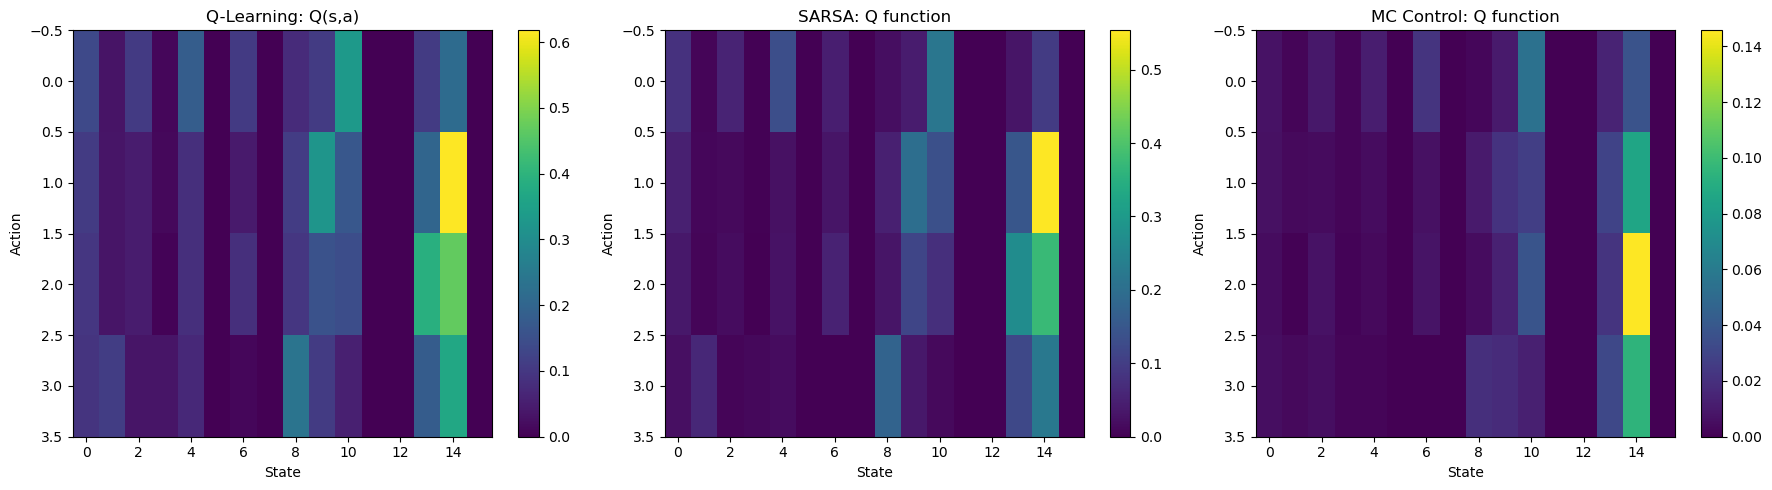

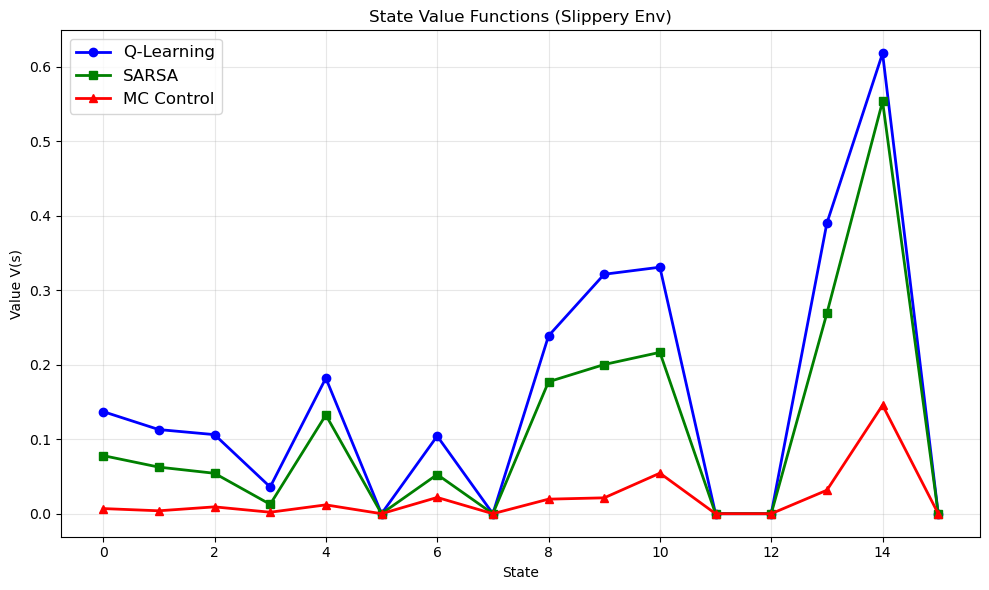

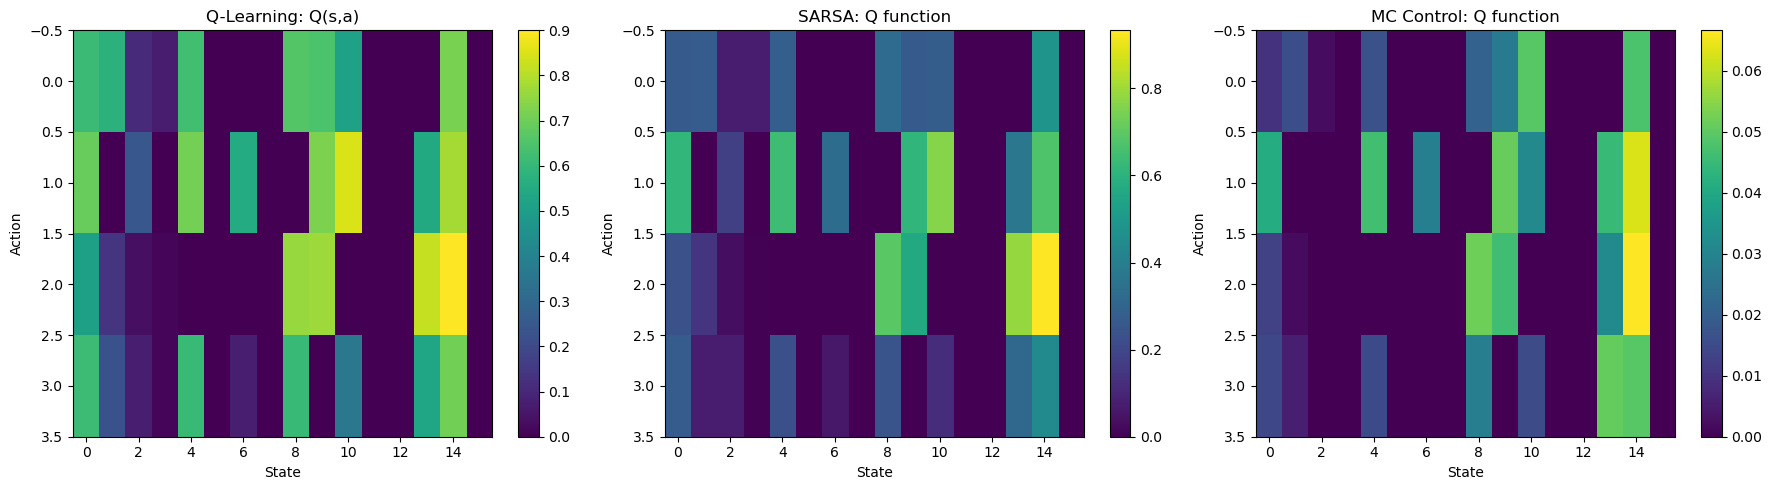

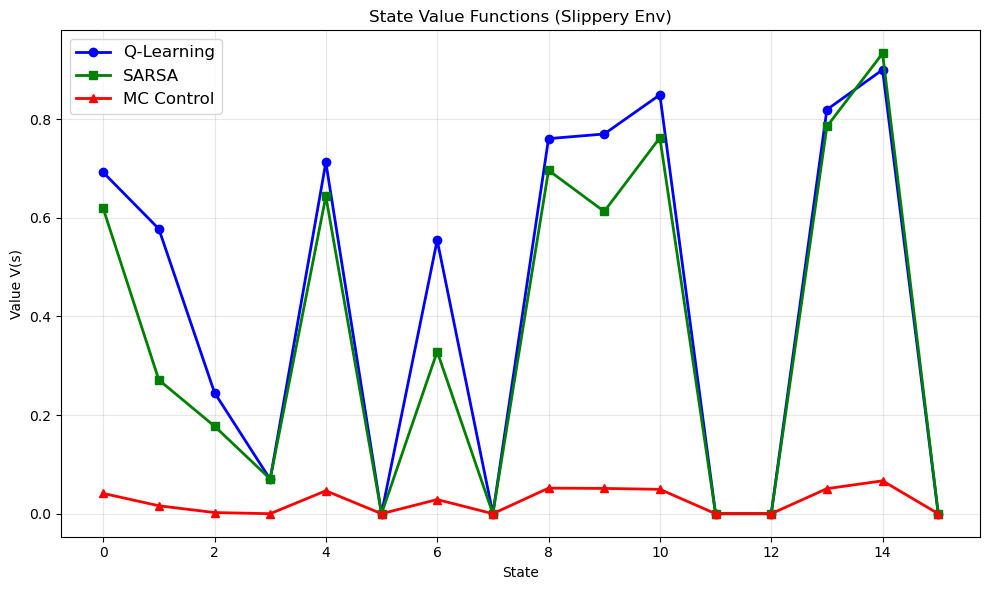

In [16]:
def plot_value_functions(ql_Q_list, sarsa_Q_list, mc_Q_list, env_is_slippery):
    # Average Q-values across runs
    ql_Q_avg = np.mean(ql_Q_list, axis=0)
    sarsa_Q_avg = np.mean(sarsa_Q_list, axis=0)
    mc_Q_avg = np.mean(mc_Q_list, axis=0)
    
    # Extract V(s) = max_a Q(s,a)
    ql_V = np.max(ql_Q_avg, axis=1)
    sarsa_V = np.max(sarsa_Q_avg, axis=1)
    mc_V = np.max(mc_Q_avg, axis=1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Q-Learning
    im1 = axes[0].imshow(ql_Q_avg.T, cmap='viridis', aspect='auto')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Action')
    axes[0].set_title('Q-Learning: Q(s,a)')
    plt.colorbar(im1, ax=axes[0])
    
    # SARSA
    im2 = axes[1].imshow(sarsa_Q_avg.T, cmap='viridis', aspect='auto')
    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Action')
    axes[1].set_title('SARSA: Q function')
    plt.colorbar(im2, ax=axes[1])
    
    # MC Control
    im3 = axes[2].imshow(mc_Q_avg.T, cmap='viridis', aspect='auto')
    axes[2].set_xlabel('State')
    axes[2].set_ylabel('Action')
    axes[2].set_title('MC Control: Q function')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Plot value functions V(s)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    states = np.arange(len(ql_V))
    ax.plot(states, ql_V, marker='o', linewidth=2, label='Q-Learning', color='blue')
    ax.plot(states, sarsa_V, marker='s', linewidth=2, label='SARSA', color='green')
    ax.plot(states, mc_V, marker='^', linewidth=2, label='MC Control', color='red')
    
    ax.set_xlabel('State')
    ax.set_ylabel('Value V(s)')
    if env_is_slippery:
        ax.set_title('State Value Functions (Slippery Env)')
    else:
        ax.set_title('State Value Functions (Non-Slippery Env)')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot value functions
plot_value_functions(ql_Q, sarsa_Q, mc_Q, env_slippery)
plot_value_functions(ql_Q_ns, sarsa_Q_ns, mc_Q_ns, env_non_slippery)

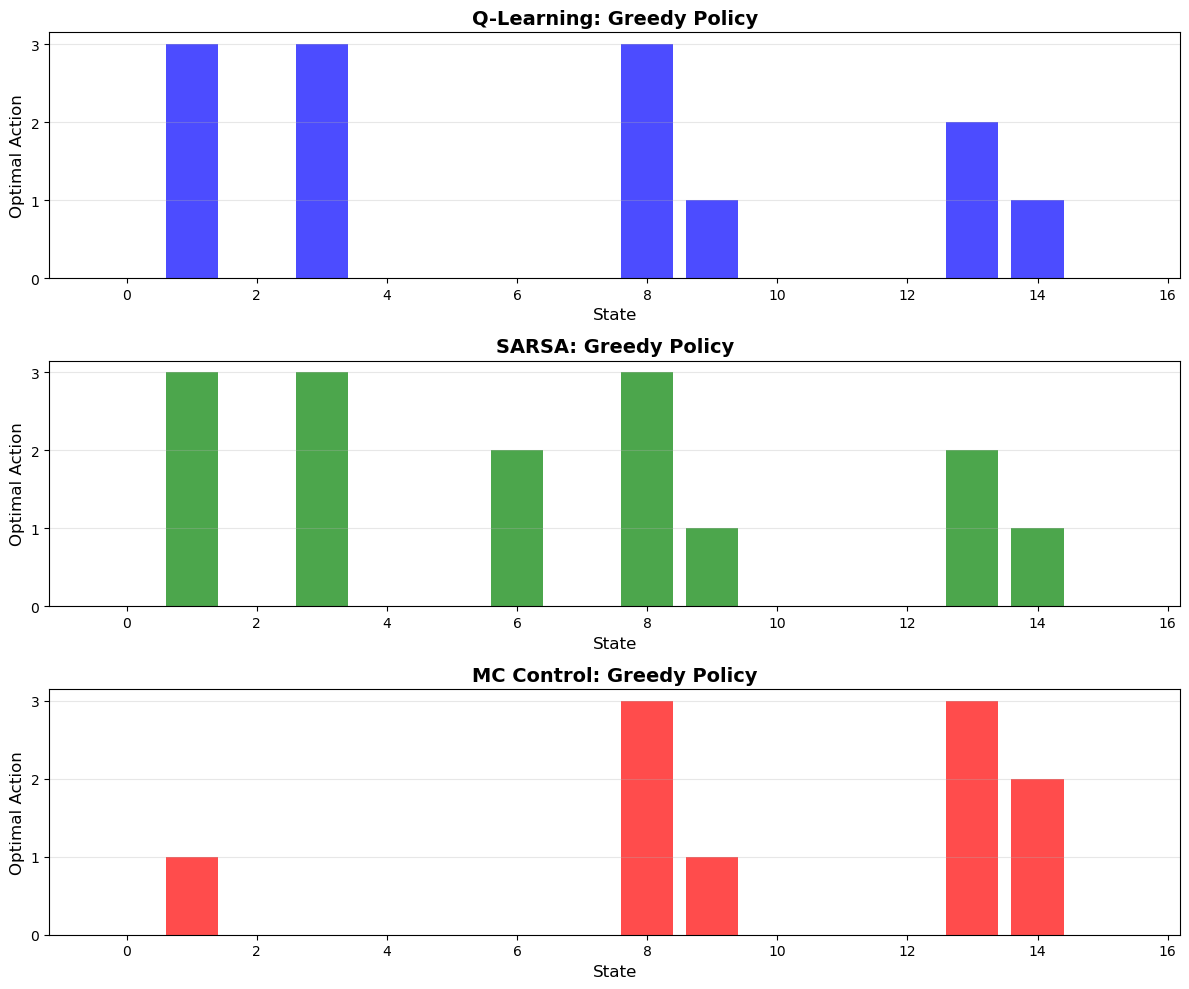

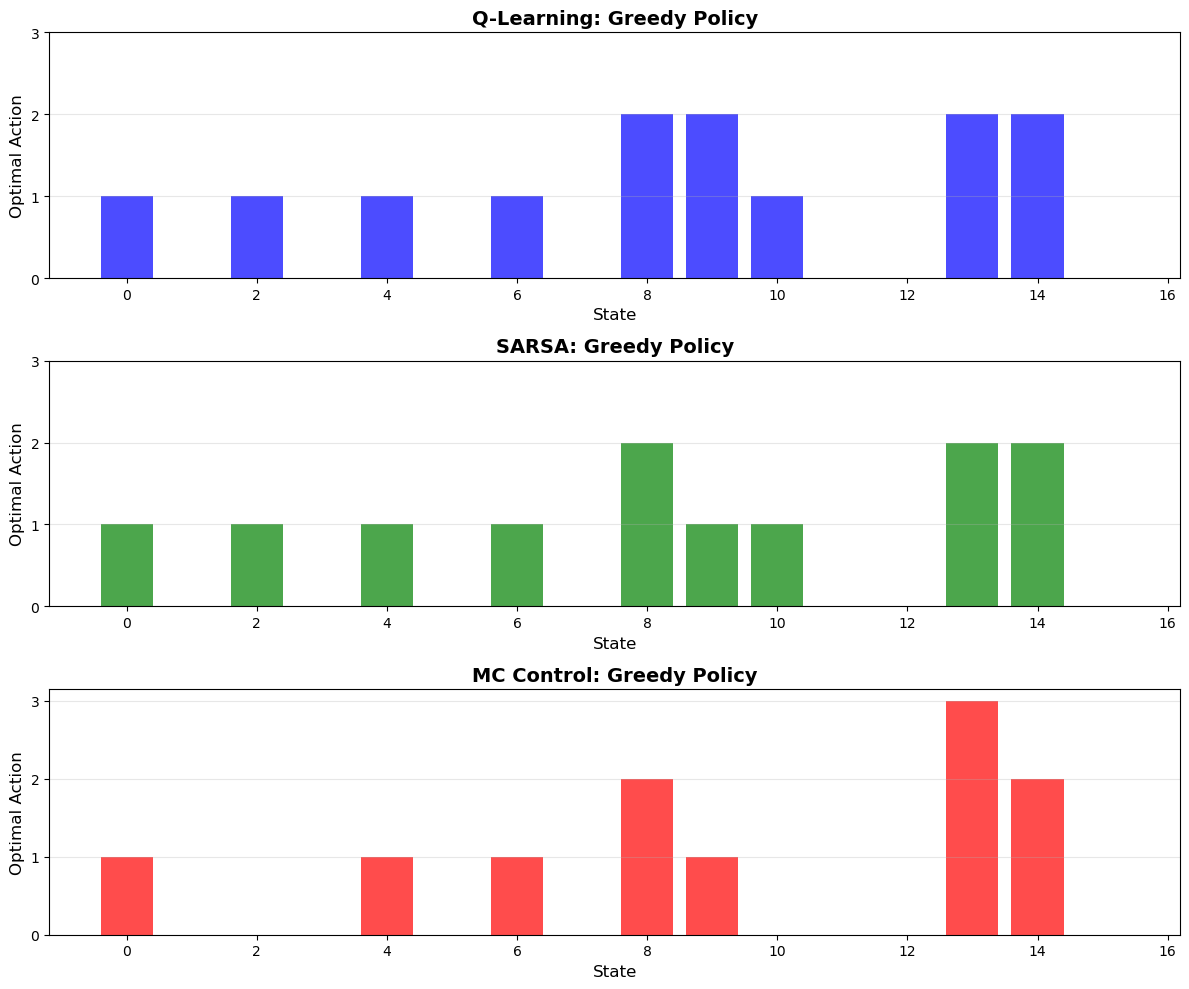

In [18]:
def plot_policies(ql_Q_list, sarsa_Q_list, mc_Q_list, env):
    """Visualize learned policies"""
    
    # Average Q-values
    ql_Q_avg = np.mean(ql_Q_list, axis=0)
    sarsa_Q_avg = np.mean(sarsa_Q_list, axis=0)
    mc_Q_avg = np.mean(mc_Q_list, axis=0)
    
    # Extract greedy policies
    ql_policy = np.argmax(ql_Q_avg, axis=1)
    sarsa_policy = np.argmax(sarsa_Q_avg, axis=1)
    mc_policy = np.argmax(mc_Q_avg, axis=1)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Q-Learning policy
    axes[0].bar(range(len(ql_policy)), ql_policy, color='blue', alpha=0.7)
    axes[0].set_xlabel('State', fontsize=12)
    axes[0].set_ylabel('Optimal Action', fontsize=12)
    axes[0].set_title('Q-Learning: Greedy Policy', fontsize=14, fontweight='bold')
    axes[0].set_yticks(range(env.action_space.n))
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # SARSA policy
    axes[1].bar(range(len(sarsa_policy)), sarsa_policy, color='green', alpha=0.7)
    axes[1].set_xlabel('State', fontsize=12)
    axes[1].set_ylabel('Optimal Action', fontsize=12)
    axes[1].set_title('SARSA: Greedy Policy', fontsize=14, fontweight='bold')
    axes[1].set_yticks(range(env.action_space.n))
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # MC Control policy
    axes[2].bar(range(len(mc_policy)), mc_policy, color='red', alpha=0.7)
    axes[2].set_xlabel('State', fontsize=12)
    axes[2].set_ylabel('Optimal Action', fontsize=12)
    axes[2].set_title('MC Control: Greedy Policy', fontsize=14, fontweight='bold')
    axes[2].set_yticks(range(env.action_space.n))
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('policies.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot policies
plot_policies(ql_Q, sarsa_Q, mc_Q, env_slippery)
plot_policies(ql_Q_ns, sarsa_Q_ns, mc_Q_ns, env_non_slippery)